Inicializando Dota2 Autoencoder...
Carregando dataset...
Tier: ['professional'], Duração: 30-120 minutos
Patches: 7.36 (10844)
512
Iniciando treinamento do Dota2 Autoencoder...
Tamanho dos dados de treino: 4389, Tamanho dos dados de validação: 877, Tamanho dos dados de teste: 877
Total de estatísticas de heróis: 11, Total de estatísticas de jogadores: 8
Treinando Dota2 Autoencoder...
Iniciando treinamento do modelo com 100 épocas
Epoch 1/100, Loss: 57.6958, Val Loss: 9.8505
Epoch 10/100, Loss: 8.4304, Val Loss: 1.5204
Epoch 20/100, Loss: 0.9388, Val Loss: 0.1624
Epoch 30/100, Loss: 0.0638, Val Loss: 0.0098
Epoch 40/100, Loss: 0.0031, Val Loss: 0.0004
Epoch 50/100, Loss: 0.0001, Val Loss: 0.0000
Early stopping ativado após 57 épocas.
Epoch 57/100, Loss: 0.0000, Val Loss: 0.0000
Histórico de loss salvo em ./tmp/dota2_2025-06-09 21-33-21_56_history.csv
Modelo salvo em ./tmp/dota2_2025-06-09 21-33-21_56_model.h5 e histórico de perda salvo em ./tmp/dota2_2025-06-09 21-33-21_56_history.csv.


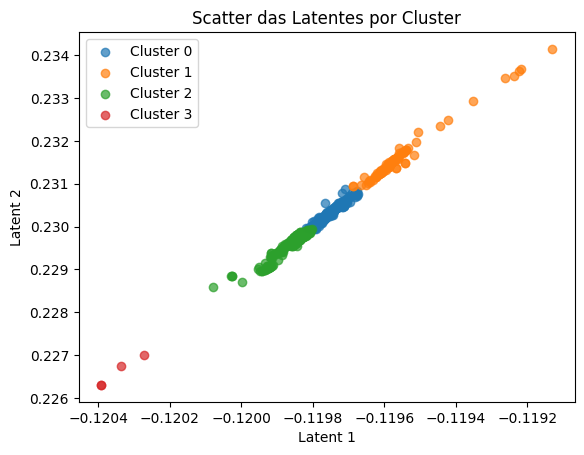

In [ ]:
import torch
import kagglehub
import numpy as np
import polars as pl
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from dota import Dota2
from model import Dota2Autoencoder
from dataset import get_dataset
from leagues import get_tier_one
from model import Dota2Autoencoder
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

train_patches = [56]
dota = Dota2(train_patches, ['professional'], (30, 120))
autoencoder, loss = dota.train_autoencoder(100)

matches = get_tier_one(dota.path)

ti_2024, _, _ = get_dataset(dota.path, specific_patches=[56])
ti_2023, _, _ = get_dataset(dota.path, specific_patches=[53])
ti_2022, _, _ = get_dataset(dota.path, specific_patches=[51])
ti_2021, _, _ = get_dataset(dota.path, specific_patches=[49, 48])

matches_ti_2024 = ti_2024.join(matches, on="league_id", how="inner").filter(pl.col("league_name") == "The International 2024")
matches_ti_2023 = ti_2023.join(matches, on="league_id", how="inner").filter(pl.col("league_name") == "The International 2023")
matches_ti_2022 = ti_2022.join(matches, on="league_id", how="inner").filter(pl.col("league_name") == "The International 2022")
matches_ti_2021 = ti_2021.join(matches, on="league_id", how="inner").filter(pl.col("league_name") == "The International 2021")

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_np = matches_ti_2024.to_numpy()


total_similarity = 0
autoencoder.eval()
encoded = []
matches_encoded = []
with torch.no_grad():
    for batch in matches_ti_2024.iter_slices(32):
        data_np = batch.to_numpy()
        matches_encoded.append(batch.select("match_id").to_numpy())
        latent, reconstructed = autoencoder.encode(data_np, min(32, batch.shape[0]), matches_ti_2024.columns)
        similarity = torch.cosine_similarity(autoencoder.flatten(data_np, min(32, batch.shape[0]), matches_ti_2024.columns), reconstructed)
        total_similarity += similarity.sum().item()
        encoded.append(latent.cpu().numpy())


print(f"Total similarity: {total_similarity / len(matches_ti_2024)}")
# Junta todos os latents em um único array
all_latents = np.concatenate(encoded, axis=0)
print(f"Latents shape: {all_latents.shape}")

# Classifica usando kmeans
cluster_labels = kmeans.fit_predict(all_latents)
print(f"Cluster labels: {np.unique(cluster_labels)}")
for cluster_id in np.unique(cluster_labels):
    cluster_points = all_latents[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title("Scatter das Latentes por Cluster")
plt.legend()
plt.show()
def plot_latent_3d(latents, labels, indices=(0, 1, 2), title="Scatter 3D das Latentes por Cluster"):
    """
    Plota um scatter 3D dos latentes usando os índices fornecidos.
    latents: np.ndarray de shape (n_samples, n_latents)
    labels: np.ndarray de shape (n_samples,)
    indices: tupla de 3 índices para usar como eixos
    """
    if latents.shape[1] < 3:
        print("O número de latentes é menor que 3, não é possível plotar em 3D.")
        return
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    for cluster_id in np.unique(labels):
        cluster_points = latents[labels == cluster_id]
        ax.scatter(cluster_points[:, indices[0]], cluster_points[:, indices[1]], cluster_points[:, indices[2]],
                   label=f"Cluster {cluster_id}", alpha=0.7)
    ax.set_xlabel(f"Latent {indices[0]+1}")
    ax.set_ylabel(f"Latent {indices[1]+1}")
    ax.set_zlabel(f"Latent {indices[2]+1}")
    ax.set_title(title)
    ax.legend()
    plt.show()

DBSCAN clusters encontrados: [0]


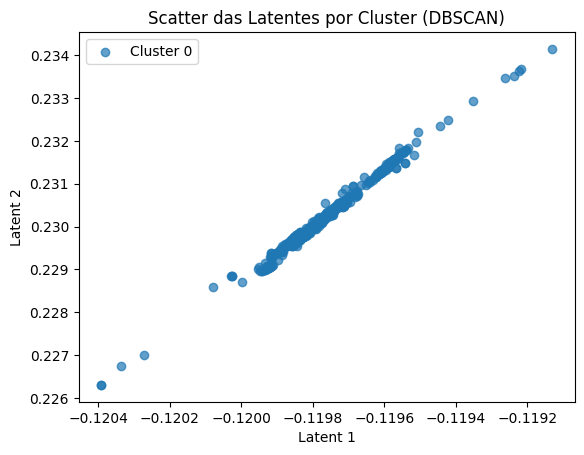

In [4]:

# Ajusta DBSCAN nos latentes
dbscan = DBSCAN(eps=0.1, min_samples=20)
dbscan_labels = dbscan.fit_predict(all_latents)

print(f"DBSCAN clusters encontrados: {np.unique(dbscan_labels)}")
for cluster_id in np.unique(dbscan_labels):
    if cluster_id == -1:
        label = "Ruído"
    else:
        label = f"Cluster {cluster_id}"
    cluster_points = all_latents[dbscan_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=label, alpha=0.7)

plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title("Scatter das Latentes por Cluster (DBSCAN)")
plt.legend()
plt.show()

In [ ]:
# Para cada cluster, crie um DataFrame separado com as partidas daquele cluster
all_match_ids = np.concatenate(matches_encoded, axis=0).flatten()

cluster_dfs = {}
for cluster_id in np.unique(cluster_labels):
    cluster_match_ids = all_match_ids[cluster_labels == cluster_id]
    # Filtra o DataFrame original pelas partidas deste cluster
    cluster_df = matches_ti_2024.filter(pl.col("match_id").is_in(cluster_match_ids))
    cluster_dfs[cluster_id] = cluster_df
    print(f"Cluster {cluster_id}: {cluster_df.shape[0]} partidas")
    # Exemplo: mostrar as 5 primeiras partidas do cluster
    display(cluster_df.select("match_id", "league_name").head(5))

# Agora cluster_dfs[0], cluster_dfs[1], ... contêm os DataFrames de cada cluster

Cluster 0: 502 partidas


match_id,league_name
i64,str
7380278774,"""The International 2023"""
7439118053,"""ESL One Kuala Lumpur Qualifier…"
7378785114,"""The International 2023"""
7332909494,"""BetBoom Dacha """
7332909494,"""BetBoom Dacha """


Cluster 1: 133 partidas


match_id,league_name
i64,str
7333563190,"""BetBoom Dacha """
7333563190,"""BetBoom Dacha """
7434440206,"""ESL One Kuala Lumpur Qualifier…"
7443231469,"""ESL One Kuala Lumpur Qualifier…"
7380454553,"""The International 2023"""


Cluster 2: 286 partidas


match_id,league_name
i64,str
7443382605,"""ESL One Kuala Lumpur Qualifier…"
7483157899,"""ESL One Kuala Lumpur powered b…"
7439048971,"""ESL One Kuala Lumpur Qualifier…"
7437280975,"""ESL One Kuala Lumpur Qualifier…"
7441532680,"""ESL One Kuala Lumpur Qualifier…"


Cluster 3: 4 partidas


match_id,league_name
i64,str
7438602051,"""ESL One Kuala Lumpur Qualifier…"
7438597952,"""ESL One Kuala Lumpur Qualifier…"
7281601207,"""BetBoom Dacha """
7281601207,"""BetBoom Dacha """
